In [1]:
import numpy as np
import polars as pl
import statsmodels.api as sm

- filter for white male hispanics
- dummy region
    - north 
    - south 
    - west
- dummy marital status
    - married
    - windowed | divoreced 
    - seperated

In [2]:
df = pl.read_excel("data/cps09mar.xlsx")
df = df.filter(
    (pl.col("female") == 0) 
    & (pl.col("hisp") == 1)
    )
df = df.with_columns(
    north_dummy=pl.when(pl.col("region") == 1).then(1).otherwise(0),
    south_dummy=pl.when(pl.col("region") == 3).then(1).otherwise(0),
    west_dummy=pl.when(pl.col("region") == 4).then(1).otherwise(0),
    married_dummy=pl.when((pl.col("marital") == 1) | (pl.col("marital") == 2) | (pl.col("marital") == 3)).then(1).otherwise(0),
    widowed_dummy=pl.when((pl.col("marital") == 4) ).then(1).otherwise(0),
    seperated_dummy=pl.when((pl.col("marital") == 5) | (pl.col("marital") == 6)).then(1).otherwise(0),
    wage=(pl.col("earnings")/(pl.col("hours") * pl.col("week"))).log(),
    exp=(pl.col("age")-pl.col("education")),
    exp_2=(pl.col("age")-pl.col("education"))**2

)

In [3]:
df.columns

['age',
 'female',
 'hisp',
 'education',
 'earnings',
 'hours',
 'week',
 'union',
 'uncov',
 'region',
 'race',
 'marital',
 'north_dummy',
 'south_dummy',
 'west_dummy',
 'married_dummy',
 'widowed_dummy',
 'seperated_dummy',
 'wage',
 'exp',
 'exp_2']

In [4]:
data = df.to_pandas()
Y = data["wage"].values.reshape(-1,1)
X = data[[
    "education", 
    'north_dummy',
    'south_dummy',
    'west_dummy',
    'married_dummy',
    'widowed_dummy',
    'seperated_dummy',
    'exp',
    'exp_2'
    ]].values.reshape(-1,9)
X = sm.add_constant(X)

In [5]:
np.linalg.pinv(X.T @ X) @ X.T @ Y

array([[ 1.00185354e+00],
       [ 8.84839510e-02],
       [ 5.74032431e-02],
       [-7.29057168e-02],
       [ 2.31315644e-02],
       [ 1.68244231e-01],
       [ 1.85317920e-01],
       [ 5.23125163e-02],
       [ 3.36609630e-02],
       [-3.87349837e-04]])

In [6]:
df = pl.read_excel("data/Koop_Tobias_subsample.xlsx")
df

Person,Education,lwage,Experience,Ability,Mothers_Educ,Fathers_Educ,Siblings
i64,i64,f64,i64,f64,i64,i64,i64
1,13,1.82,1,1.0,12,12,1
2,15,2.14,4,1.5,12,12,1
3,10,1.56,1,-0.36,12,12,1
4,12,1.85,1,0.26,12,10,4
5,15,2.41,2,0.3,12,12,1
…,…,…,…,…,…,…,…
11,12,2.44,1,1.82,16,17,2
12,13,2.41,4,-1.3,13,12,5
13,12,2.07,3,-0.63,12,12,4


In [7]:
data = df.to_pandas()
Y = data["lwage"].values.reshape(-1, 1)
X_1 = data[["Education", "Experience", "Ability"]].values.reshape(-1,3)
# X_1 = sm.add_constant(X_1)

n = len(Y)
p = 3

beta_1 = np.linalg.pinv(X_1.T @ X_1) @ X_1.T @ Y

y_pred = X_1 @ beta_1

ss_res = np.sum((Y - y_pred) ** 2)
ss_tot = np.sum((Y - np.mean(Y)) ** 2)
r_squared = 1 - ss_res / ss_tot

r_squared_adj = 1 - ((1 - r_squared) * (n - 1)) / (n - p - 1)

print("R²:", r_squared)
print(beta_1)
print("Adjusted R²:", r_squared_adj)


R²: -0.35368978328003076
[[ 0.14176611]
 [ 0.08210773]
 [-0.04027553]]
Adjusted R²: -0.7228779059927666


In [8]:
data = df.to_pandas()
Y = data["lwage"].values.reshape(-1, 1)
X_1 = data[["Mothers_Educ", 'Fathers_Educ','Siblings']].values.reshape(-1,3)
# X_1 = sm.add_constant(X_1)
n = len(Y)
p = 3

# Fit the model
beta_1 = np.linalg.pinv(X_1.T @ X_1) @ X_1.T @ Y

# Predictions
y_pred = X_1 @ beta_1

# R²
ss_res = np.sum((Y - y_pred) ** 2)
ss_tot = np.sum((Y - np.mean(Y)) ** 2)
r_squared = 1 - ss_res / ss_tot

# Adjusted R²
r_squared_adj = 1 - ((1 - r_squared) * (n - 1)) / (n - p - 1)

print("R²:", r_squared)
print(beta_1)
print("Adjusted R²:", r_squared_adj)


R²: -0.021858111562357507
[[0.10278715]
 [0.0490232 ]
 [0.08474073]]
Adjusted R²: -0.3005466874430005


In [9]:
data = df.to_pandas()
Y = data["lwage"].values.reshape(-1, 1)
X_1 = data[["Education", "Experience", "Ability","Mothers_Educ", 'Fathers_Educ','Siblings']].values.reshape(-1,6)

n = len(Y)
p = 6

# Fit the model
beta_1 = np.linalg.pinv(X_1.T @ X_1) @ X_1.T @ Y

# Predictions
y_pred = X_1 @ beta_1

# R²
ss_res = np.sum((Y - y_pred) ** 2)
ss_tot = np.sum((Y - np.mean(Y)) ** 2)
r_squared = 1 - ss_res / ss_tot

# Adjusted R²
r_squared_adj = 1 - ((1 - r_squared) * (n - 1)) / (n - p - 1)

print("R²:", r_squared)
print(beta_1)
print("Adjusted R²:", r_squared_adj)


R²: 0.5159728212542856
[[0.02729688]
 [0.10414245]
 [0.02862099]
 [0.10390239]
 [0.0017645 ]
 [0.05896747]]
Adjusted R²: 0.15295243719499974


In [10]:
residuals = [] # c
# df  = df.to_pandas()
X1_vars = [
    "Education", 
    'Experience',
    'Ability',
    ]
X2_vars = [
    "Mothers_Educ", 
    'Fathers_Educ',
    'Siblings',
    ]


X1 = sm.add_constant(data[X1_vars].values.reshape(-1,3))

for var in X2_vars:
    Y = data[var].values.reshape(-1,1)
    bata_hat = np.linalg.pinv(X1.T @ X1) @ X1.T @ Y
    res = Y - X1 @ bata_hat
    residuals.append(res)

X2_star2 = np.column_stack(residuals)
X2_star2


array([[-0.88905947, -1.22150878, -0.68682437],
       [-0.11517713, -1.71475472,  0.05469225],
       [-0.45629625,  0.04565311, -2.1323313 ],
       [-0.60064848, -2.54894445,  1.55677955],
       [-0.08365762, -0.66525293, -1.20618917],
       [-0.15405967,  3.21256759, -0.07210152],
       [-0.10444609, -1.19873093, -0.56617077],
       [ 0.21523766,  2.20274575,  0.01120688],
       [-0.5326941 , -1.10045385,  0.23486732],
       [ 0.45949065, -0.52668416, -0.26775012],
       [ 2.61487153,  3.08962704,  1.05089911],
       [ 2.1254356 ,  0.7823519 ,  1.27764509],
       [ 0.41883404,  0.22551886,  0.81592389],
       [-0.85905139, -0.01348665, -0.75814046],
       [-2.03877928, -0.56864777,  0.68749362]])

In [11]:
import arviz as az
import numpy as np
import pandas as pd
import bambi as bmb
from sklearn.linear_model import LinearRegression

In [12]:
RANDOM_SEED = 7876
rng = np.random.default_rng(RANDOM_SEED)

az.style.use("arviz-darkgrid")

In [13]:
def mc_func(size,intercept,slope,SEED=787):
    rng = np.random.default_rng(SEED)
    x = np.linspace(0, 1, size)
    true_regression_line = intercept + slope * x
    y = true_regression_line + rng.normal(scale=3, size=size)
    data = pd.DataFrame({"x": x, "y": y})
    model = bmb.Model("y ~ x", data)
    idata = model.fit(draws=1000, chains=1)
    return idata

idata1 = mc_func(size=25, slope=2, intercept=1)
idata2 = mc_func(size=50, slope=2, intercept=1)
idata3 = mc_func(size=100, slope=2, intercept=1)



Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, Intercept, x]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, Intercept, x]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, Intercept, x]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 0 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [14]:
true_intercept = 1
true_slope = 2

def asymptotic_variance(size, intercept, slope, seed=787):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 1, size)
    true_regression_line = intercept + slope * x
    y = true_regression_line + rng.normal(scale=3, size=size)
    data = pd.DataFrame({"x": x, "y": y})

    # Fit OLS
    model = LinearRegression().fit(data[["x"]], data["y"])
    residuals = data["y"] - model.predict(data[["x"]])
    sigma_sq = np.var(residuals, ddof=1)
    x_centered = data["x"] - data["x"].mean()
    var_beta1 = sigma_sq / np.sum(x_centered**2)
    
    return var_beta1

asymp_var_25 = asymptotic_variance(25, true_intercept, true_slope)
asymp_var_50 = asymptotic_variance(50, true_intercept, true_slope)
asymp_var_100 = asymptotic_variance(100, true_intercept, true_slope)


In [15]:
def bootstrap_slope_variance(size, intercept, slope, n_bootstrap=1000, seed=787):
    rng = np.random.default_rng(seed)
    x = np.linspace(0, 1, size)
    true_regression_line = intercept + slope * x
    y = true_regression_line + rng.normal(scale=3, size=size)
    data = pd.DataFrame({"x": x, "y": y})

    coefs = []
    for _ in range(n_bootstrap):
        sample = data.sample(n=size, replace=True, random_state=rng.integers(1e6))
        model = LinearRegression().fit(sample[["x"]], sample["y"])
        coefs.append(model.coef_[0])
    
    return np.var(coefs)

boot_var_25 = bootstrap_slope_variance(25, true_intercept, true_slope)
boot_var_50 = bootstrap_slope_variance(50, true_intercept, true_slope)
boot_var_100 = bootstrap_slope_variance(100, true_intercept, true_slope)


In [16]:
# Extract posterior samples for slope coefficient
import arviz as az

posterior_slope_25 = idata1.posterior["x"].values.flatten()
posterior_slope_50 = idata2.posterior["x"].values.flatten()
posterior_slope_100 = idata3.posterior["x"].values.flatten()

# Calculate posterior variances
posterior_var_25 = posterior_slope_25.var()
posterior_var_50 = posterior_slope_50.var()
posterior_var_100 = posterior_slope_100.var()


In [17]:
true_intercept = 1
true_slope = 2

array([[<Axes: title={'center': 'x'}>]], dtype=object)

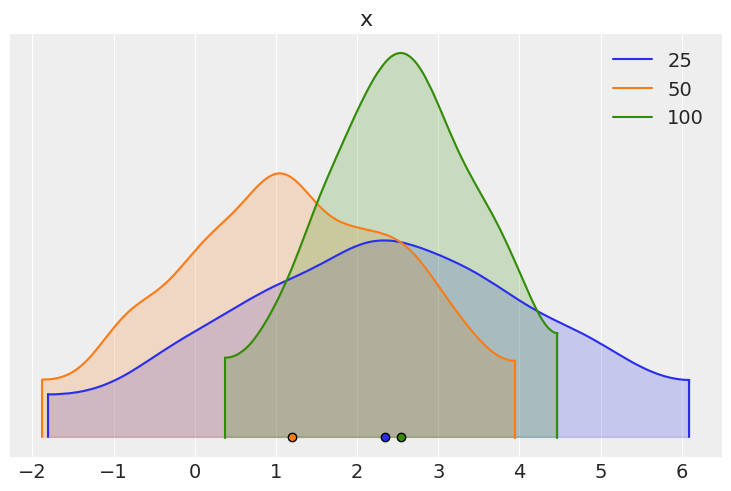

In [18]:
az.plot_density(
    [idata1, idata2, idata3],
        var_names=["x"],
    data_labels=["25", "50", "100"],
    shade=0.2,
)


In [19]:
df = pd.DataFrame({
    "Sample Size": [25, 50, 100],
    "Posterior Var": [posterior_var_25, posterior_var_50, posterior_var_100],
    "Asymptotic Var": [asymp_var_25, asymp_var_50, asymp_var_100],
    "Bootstrap Var": [boot_var_25, boot_var_50, boot_var_100]
})

print(df)


   Sample Size  Posterior Var  Asymptotic Var  Bootstrap Var
0           25       4.587303        4.070104       3.484380
1           50       2.539172        2.327265       2.142014
2          100       1.193076        1.073991       1.129780
